experiments path: out/*/
experiments list: ['out/DQN_vs_PPOabundant_high_n_p/', 'out/DQN_vs_PPOscarse_high_n_f/']
------------------------------------------
showing experiment: out/DQN_vs_PPOabundant_high_n_p/ 

Meta:
	Number of iterations player0: 61
	Number of iterations player1: 61
	Number of total episodes player 0: 244
	Number of total episodes player 1: 244

Reward Plot:


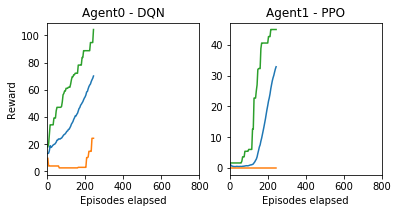

------------------------------------------
showing experiment: out/DQN_vs_PPOscarse_high_n_f/ 

Meta:
	Number of iterations player0: 61
	Number of iterations player1: 61
	Number of total episodes player 0: 244
	Number of total episodes player 1: 244

Reward Plot:


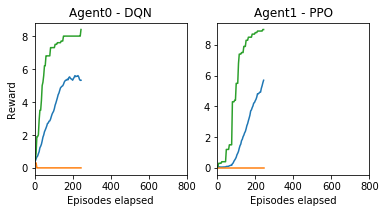

In [15]:
%matplotlib inline

# use this cell to monitor training

import os
import glob
import matplotlib
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import json
import pprint
from sklearn.preprocessing import MinMaxScaler

experiment_path = "out/*/"
EPISODE_NORMALISATION=800


def parse(path):
    df = pd.read_csv(path, index_col="episodes_total")
    episodes_per_step = df.index.to_list()
    episode_reward_max = df['episode_reward_max'].to_list()
    episode_reward_min = df['episode_reward_min'].to_list()
    episode_reward_mean = df['episode_reward_mean'].to_list()
    assert(len(episode_reward_mean) == len(episode_reward_min) == len(episode_reward_max))
    return (episodes_per_step,
            episode_reward_max,
            episode_reward_min,
            episode_reward_mean)

def s(a3,a2,a1):
    sds2 = len(a3)
    a3 = np.array(a3).reshape(-1,1)
    a2 = np.array(a2).reshape(-1,1)
    a1 = np.array(a1).reshape(-1,1)
    cc=np.concatenate([a3,a2,a1], axis=0)
    x_sample = [0, 50_000]
    scaler = MinMaxScaler(feature_range=(0, 100))
    scaler.fit(np.array(x_sample)[:, np.newaxis])
    abnormal_data = scaler.transform(cc)
    r3 = abnormal_data[0:sds2]
    r2 = abnormal_data[sds2:sds2*2]
    r1 = abnormal_data[sds2*2:]
    return  r3, r2, r1
 
def show(player1, player2, x=None):
    print("Meta:")
    print("\tNumber of iterations player0:", len(player1[0]))
    print("\tNumber of iterations player1:", len(player2[0]))
    print("\tNumber of total episodes player 0:", player1[0][-1])
    print("\tNumber of total episodes player 1:", player2[0][-1])

    fig = plt.figure(figsize=(6, 2.8))
    plt.subplot(1, 2, 1)
     
    if x is not None and "PPO_vs_PPO" in x:
        plt.title("Agent0 - PPO")
    else:
        plt.title("Agent0 - DQN")
        
    s3, s2, s1 = s(player1[3], player1[2], player1[1])
    
    plt.plot(player1[0], s3,  label="avg reward")
    plt.plot(player1[0], s2,  label="min reward")
    plt.plot(player1[0], s1,  label="max reward")
    plt.xlim((0, EPISODE_NORMALISATION))
    plt.ylabel("Reward")
    plt.xlabel("Episodes elapsed")
    plt.subplot(1, 2, 2)
    s3, s2, s1 = s(player2[3], player2[2], player2[1])
   
    if  x is not None and "DQN_vs_DQN" in x:
        plt.title("Agent1 - DQN")
    else:
        plt.title("Agent1 - PPO")

    plt.plot(player2[0], s3,  label="avg reward")
    plt.plot(player2[0], s2,  label="min reward")
    plt.plot(player2[0], s1,  label="max reward")
    plt.xlabel("Episodes elapsed")
    plt.xlim((0, EPISODE_NORMALISATION))
    print("\nReward Plot:")
    plt.show()
    
print("experiments path:", experiment_path)
experiments=glob.glob(experiment_path)
print("experiments list:", experiments)

for x in experiments:
    print('------------------------------------------')
    print("showing experiment:", x, "\n")

    with open(os.path.join(x,"experiment.json")) as json_file:
        data = json.load(json_file)
    
    parameters = os.path.join(x, "player1/progress.csv")
    try:
        results_path_player1 = os.path.join(x, "player1/progress.csv")
        results_path_player0 = os.path.join(x, "player0/progress.csv")
        show(parse(results_path_player0), parse(results_path_player1), x)
    except:
        print("\tskipping", x)

In [14]:
# use this cell to view evaluation results, not the 'evaluate.py' script needs to be executed before this is possible.

from IPython.core.display import display, HTML
from IPython.display import display_html
import collections  
import pandas as pd

def flatten(d, parent_key='', sep='_'):
    items = []
    for k, v in d.items():
        new_key = parent_key + sep + k if parent_key else k
        if isinstance(v, collections.MutableMapping):
            items.extend(flatten(v, new_key, sep=sep).items())
        else:
            items.append((new_key, v))
    return dict(items)

def display_side_by_side(*args):
    html_str=''
    for df in args:
        html_str+=df.to_html()
    display_html(html_str.replace('table','table style="display:inline"'),raw=True)
    
def ss(x):
    return round((100)*(x-0)/(50_000-0), 3)
    print()
def showvideo(video_number):
    display(HTML("""<video width="300" height="300" controls><source src="{}" type="video/mp4"></video>""".format(video_number)))
    
datas = {}

for x in experiments:
    results_file = os.path.join(x,"results_eval.json")

    if not os.path.exists(results_file):
        print('ERROR: no results for experiment [', x, "] use `evaluate.py' first.")
        continue

    print('------------------------------------------')
    print("showing experiment:", x, "\n")
    results_path_player1 = os.path.join(x, "player1/progress.csv")
    results_path_player0 = os.path.join(x, "player0/progress.csv") 
    show(parse(results_path_player0), parse(results_path_player1))

    with open(os.path.join(x,"experiment.json")) as json_file:
        parameters = json.load(json_file)
    
        if "exploration_config" in parameters['agent0_configs']:
            parameters['agent0_configs']['exp_c'] = parameters['agent0_configs'].pop('exploration_config')
        if "exploration_config" in parameters['agent1_configs']:
            parameters['agent1_configs']['exp_c'] = parameters['agent1_configs'].pop('exploration_config')
        
        agent0config = pd.DataFrame([flatten(parameters['agent0_configs'])]).T
        agent0config.columns = ['player0']
        agent1config = pd.DataFrame([flatten(parameters['agent1_configs'])]).T
        agent1config.columns = ['player1']
        env = pd.DataFrame([parameters['env_configs']]).T
    
    with open(results_file) as json_file:
        data = json.load(json_file)
        showvideo(os.path.join(x,"render/output.mp4"))
        d = pd.DataFrame(0, index= list(data['player0_action_distribution'].keys()) + ['median reward', 'avg reward', "algo"], columns=['player0', 'player1'])
        l1 = list(data['player0_action_distribution'].values())
        l2 = list(data['player1_action_distribution'].values()) 
            
        l1 = [round(x, 3) for x in l1]
        l2 = [round(x, 3) for x in l2]
        d['player0']= l1 + [ss(data['player0_median']), ss(data['player0_reward']), parameters['agent0_alg']]
        d['player1'] = l2 + [ss(data['player1_median']), ss(data['player1_reward']), parameters['agent1_alg']]
        display_side_by_side(env, agent0config, agent1config)
        d = d.round(1)
        d = d.drop(['rotate_right', 'rotate_left'], axis=0)
        display(d.T)
        sdsds = x.split("/")[:-1][-1].replace("_", "-").replace("DQN-vs-PPO", "")
        datas[sdsds] = d
        print("------------------------------------------------------")

ERROR: no results for experiment [ out/DQN_vs_PPOabundant_high_n_p/ ] use `evaluate.py' first.
ERROR: no results for experiment [ out/DQN_vs_PPOscarse_high_n_f/ ] use `evaluate.py' first.


In [3]:
col = ["move_up", "move_down", "move_left", "move_right", "nothing", "shoot", "median reward", "avg reward", "algo"]

dsds = pd.DataFrame(index=datas.keys(), columns=col, dtype=str)
   
for k,v in datas.items():
    v = v.copy()
    v['player1'] = v['player1'].astype(str)
    v['player0'] = v['player0'].astype(str)
    v['player0'] = v['player0'] + " / "
    v = (v["player0"] + v["player1"])
    dsds.loc[k] = v
    
dsds= dsds.T
display(dsds)
dsds= dsds.T
dsds.columns = ["mv-up", "mv-down", "mv-left", "mv-right", "nothing", "shoot", "median-rwd", "avg-rwd", "algo"]
print(dsds.T.to_latex(escape = False))


""
move_up
move_down
move_left
move_right
nothing
shoot
median reward
avg reward
algo


\begin{tabular}{l}
\toprule
Empty DataFrame
Columns: Index([], dtype='object')
Index: Index(['mv-up', 'mv-down', 'mv-left', 'mv-right', 'nothing', 'shoot',
       'median-rwd', 'avg-rwd', 'algo'],
      dtype='object') \\
\bottomrule
\end{tabular}

